In [49]:
import numpy as np
import scipy.stats as sps

import matplotlib.pyplot as plt

Here Y ~ lognormal(shape, scale) and shape and scale are both dependent on covariants

## Step 1: generate data from unconditional distributions
* Log normal (varying scale + shape, aka mean and variance of underlying normal)
* Sums of two log-normals, as in a heterogenous population.

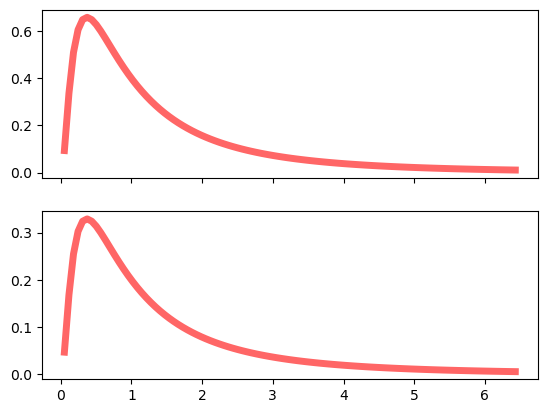

In [48]:
fig, ax = plt.subplots(2, 1, sharex=True)

x = np.linspace(
    sps.lognorm.ppf(0.0001, s),
    sps.lognorm.ppf(0.99, s), 
    100
)

ax[0].plot(
    x, sps.lognorm.pdf(x, s=1, scale=1), 'r-', lw=5, alpha=0.6, label='lognorm pdf'
)
ax[1].plot(
    x, sps.lognorm.pdf(2*x, s=1, scale=2), 'r-', lw=5, alpha=0.6, label='lognorm pdf'
)

In [ ]:
s_array = np.linspace(